Testing out the ai image detector on some random images and resizing them to be 32 x 32

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

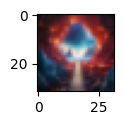

In [ ]:
image2 = imread("/content/testimage1.jpg") # 1344 / 896 = 1.5
height = 32
image2 = resize(image2, output_shape = (height, height, 3))
plt.figure(figsize = (1, 1))
plt.imshow(image2)

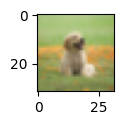

In [ ]:
image3 = imread("/content/testimage2.jpg")
image3 = resize(image3, output_shape = (height, height, 3))
plt.figure(figsize = (1, 1))
plt.imshow(image3)

In [ ]:
class CNN3D(nn.Module):

    def __init__(self):
        super(CNN3D, self).__init__()

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        # (1, 3, 32, 32)
        self.conv1 = nn.Conv3d(1, 32, kernel_size = 3, stride = 1, padding = 0)
        # (32, 1, 30, 30)
        self.bn1 = nn.BatchNorm3d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 0)
        # (32, 28, 28)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 0)
        # (32, 26, 26)
        self.bn3 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 26 * 26, 4 * n_hidden)
        self.ln_fc1 = nn.LayerNorm(4 * n_hidden)

        self.fc2 = nn.Linear(4 * n_hidden, n_hidden)
        self.ln_fc2 = nn.LayerNorm(n_hidden)

        self.fc3 = nn.Linear(n_hidden, num_classes)

    def forward(self, x):
        x = x.reshape(-1, 1, 3, 32, 32)
        x = self.relu(self.bn1(self.conv1(x)))
        x = x.reshape(-1, 32, 30, 30)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))

        x = self.flatten(x)

        x = self.relu(self.ln_fc1(self.fc1(x)))
        x = self.relu(self.ln_fc2(self.fc2(x)))
        x = self.fc3(x)

        return x

In [ ]:
batch_size = 64
total_steps = 2000
learning_rate = 3e-4
n_hidden = 512
num_classes = 2

In [ ]:
CNN3D_model = CNN3D()

In [ ]:
PATH = "/content/CNN3D_model_91percent-correct.ckpt"
CNN3D_model.load_state_dict(torch.load(PATH, torch.device('cpu')))
# optimizer = torch.optim.Adam(CNN3D_model.parameters(), lr=1e-6)

CNN3D_model.eval()

CNN3D(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=21632, out_features=2048, bias=True)
  (ln_fc1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (ln_fc2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
def image_check(image_path):
  original_image = imread(image_path)
  image_test = resize(original_image, output_shape = (32, 32, 3), preserve_range = True)
  original_image = resize(original_image, output_shape = (32, 32, 3))
  image_test = torch.tensor(np.array(image_test), dtype = torch.float32).reshape(1, 3, 32, 32)
  logits_test = CNN3D_model(image_test)
  print(logits_test)
  probs = logits_test.exp() / torch.sum(logits_test.exp(), dim = 1)
  index = torch.argmax(logits_test).item()

  plt.figure(figsize = (1, 1))
  plt.imshow(original_image)
  plt.title("Fake with confidence {:.2f}%".format(probs[0][index] * 100) if index == 1 else "Real with confidence {:.2f}%".format(probs[0][index] * 100))

tensor([[ 5.0960, -4.6538]], grad_fn=<AddmmBackward0>)


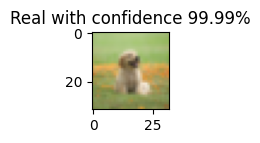

In [ ]:
image_check("/content/testimage2.jpg") # should be real

tensor([[ 4.6802, -4.1481]], grad_fn=<AddmmBackward0>)


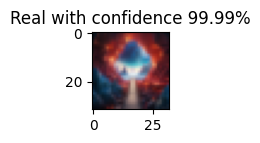

In [ ]:
image_check("/content/testimage1.jpg") # should be fake

tensor([[ 3.0370, -2.6122]], grad_fn=<AddmmBackward0>)


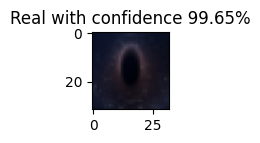

In [ ]:
image_check("/content/AdobeStock_102137132.jpg") # not sure what should be

tensor([[ 3.3668, -3.1308]], grad_fn=<AddmmBackward0>)


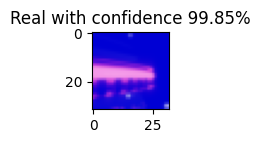

In [ ]:
image_check("/content/danosdetailingpic.png") # i think should be fake

tensor([[ 4.8221, -4.2947]], grad_fn=<AddmmBackward0>)


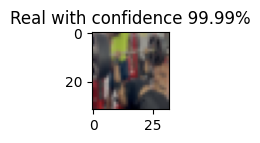

In [ ]:
image_check("/content/Larry-Wheels-and-Jerome-Pever.png") # should be real

tensor([[ 3.8781, -3.3422]], grad_fn=<AddmmBackward0>)


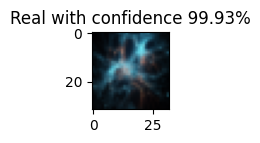

In [ ]:
image_check("/content/intro-to-gnns-16x9-1.jpg") # i think should be fake

tensor([[-4.6379,  4.0013]], grad_fn=<AddmmBackward0>)


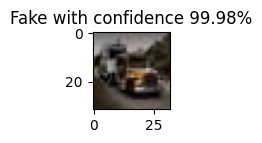

In [ ]:
image_check("/content/testimage3.jpg") # this is a fake image i pulled from cifake directly

tensor([[ 0.1428, -0.4715]], grad_fn=<AddmmBackward0>)


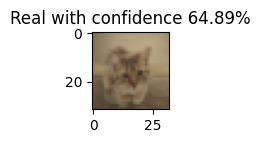

In [ ]:
image_check("/content/faketestimage1.jpg") # this is a fake image from "These cats do not exist" website

tensor([[ 5.0506, -4.6311]], grad_fn=<AddmmBackward0>)


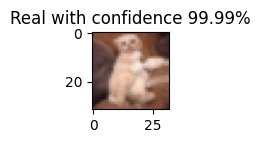

In [ ]:
image_check("/content/faketestimage2.jpg") # this is a fake image from "These cats do not exist" website

tensor([[ 4.0020, -3.5701]], grad_fn=<AddmmBackward0>)


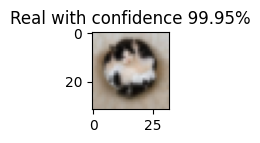

In [ ]:
image_check("/content/faketestimage3.jpg") # this is a fake image from "These cats do not exist" website

tensor([[ 3.9843, -3.7477]], grad_fn=<AddmmBackward0>)


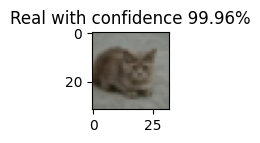

In [ ]:
image_check("/content/faketestimage4.jpg") # this is a fake image from "These cats do not exist" website

tensor([[ 5.1730, -4.6758]], grad_fn=<AddmmBackward0>)


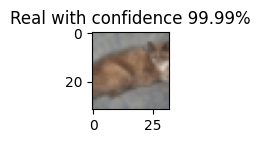

In [ ]:
image_check("/content/faketestimage5.jpg") # this is a fake image from "These cats do not exist" website